In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

import warnings
warnings.filterwarnings('ignore')

In [2]:
data_path = "/Users/praneetgogoi/Documents/brain-mri-model/brain-mri/train"

image_paths = []
labels_list = []

for class_name in os.listdir(data_path):
    class_path = os.path.join(data_path, class_name)
    if not os.path.isdir(class_path):
        continue
    
    for img_file in os.listdir(class_path):
        if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append(os.path.join(class_path, img_file))
            labels_list.append(class_name)

df = pd.DataFrame({'image_path': image_paths, 'label': labels_list})

print(f"Total Images: {len(df)}")
print(f"Number of Classes: {df['label'].nunique()}")
print("\nClass Distribution:")
class_dist = df['label'].value_counts()
print(class_dist)

Total Images: 1400
Number of Classes: 5

Class Distribution:
label
fukuyama_muscular_dystrophy         280
pachygyria_cerebellar_hypoplasia    280
walker_warburg_syndrome             280
moyamoya_disease                    280
hallervorden_spatz_disease          280
Name: count, dtype: int64


In [3]:
from sklearn.model_selection import train_test_split
strat = df['label']
train_df, temp_df = train_test_split(
    df, 
    train_size=0.8, 
    shuffle=True, 
    random_state=42, 
    stratify=strat
)

strat = temp_df['label']
val_df, test_df = train_test_split(
    temp_df, 
    train_size=0.5, 
    shuffle=True, 
    random_state=42, 
    stratify=strat
)

print(f"\nTraining Set: {train_df.shape[0]} images")
print(f"Validation Set: {val_df.shape[0]} images")
print(f"Test Set: {test_df.shape[0]} images")


Training Set: 1120 images
Validation Set: 140 images
Test Set: 140 images


In [5]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

val_generator = test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='image_path',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

class_indices = train_generator.class_indices
class_names = list(class_indices.keys())
num_classes = len(class_names)

print(f"\nNumber of classes: {num_classes}")
print(f"Class names: {class_names}")

Found 1120 validated image filenames belonging to 5 classes.


Found 140 validated image filenames belonging to 5 classes.
Found 140 validated image filenames belonging to 5 classes.

Number of classes: 5
Class names: ['fukuyama_muscular_dystrophy', 'hallervorden_spatz_disease', 'moyamoya_disease', 'pachygyria_cerebellar_hypoplasia', 'walker_warburg_syndrome']


In [6]:
base_model = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = True

for layer in base_model.layers[:100]: 
    layer.trainable = False
for layer in base_model.layers[100:]: 
    layer.trainable = True

# Build custom classifier on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"\nModel Summary:")
model.summary()


Model Summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,733,317 (29.50 MB)

 Trainable params: 6,841,925 (26.10 MB)

 Non-trainable params: 891,392 (3.40 MB)

In [7]:
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        mode='max'
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        'best_densenet121_tf_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max'
    )
]

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=callbacks,
    verbose=1
)

val_loss, val_accuracy = model.evaluate(val_generator, verbose=0)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Loss: {val_loss:.4f}")

test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2514 - loss: 1.7970

35/35 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.3536 - loss: 1.5315 - val_accuracy: 0.4500 - val_loss: 1.3399 - learning_rate: 1.0000e-04
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6603 - loss: 0.9351

35/35 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.7071 - loss: 0.8329 - val_accuracy: 0.7286 - val_loss: 0.8756 - learning_rate: 1.0000e-04
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8158 - loss: 0.6057

35/35 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.8339 - loss: 0.5415 - val_accuracy: 0.7786 - val_loss: 0.5918 - learning_rate: 1.0000e-04
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8949 - loss: 0.3555

35/35 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.8973 - loss: 0.3378 - val_accuracy: 0.8714 - val_loss: 0.3454 - learning_rate: 1.0000e-04
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9375 - loss: 0.2626

35/35 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.9357 - loss: 0.2570 - val_accuracy: 0.8929 - val_loss: 0.2706 - learning_rate: 1.0000e-04
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9563 - loss: 0.1819

35/35 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.9536 - loss: 0.1726 - val_accuracy: 0.9643 - val_loss: 0.1072 - learning_rate: 1.0000e-04
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9530 - loss: 0.1764

35/35 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.9643 - loss: 0.1403 - val_accuracy: 0.9786 - val_loss: 0.0663 - learning_rate: 1.0000e-04
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9756 - loss: 0.0933

35/35 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.9768 - loss: 0.0931 - val_accuracy: 0.9929 - val_loss: 0.0446 - learning_rate: 1.0000e-04
Epoch 9/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.9830 - loss: 0.0674 - val_accuracy: 0.9714 - val_loss: 0.0631 - learning_rate: 1.0000e-04
Epoch 10/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.9884 - loss: 0.0546 - val_accuracy: 0.9857 - val_loss: 0.0286 - learning_rate: 1.0000e-04
Epoch 11/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.9875 - loss: 0.0443 - val_accuracy: 0.9857 - val_loss: 0.0501 - learning_rate: 1.0000e-04
Epoch 12/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.9893 - loss: 0.0473 - val_accuracy: 0.9643 - val_loss: 0.0840 - learning_rate: 1.0000e-04
Epoch 13/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.9937 - loss: 0.0307 - val_accuracy: 0.9929 - val_loss: 0.0142 - learning_rate: 1.0000e-04
Epoch 14/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.9911 - loss: 0.044

35/35 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.9893 - loss: 0.0363 - val_accuracy: 1.0000 - val_loss: 0.0055 - learning_rate: 1.0000e-04
Epoch 16/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.9920 - loss: 0.0205 - val_accuracy: 1.0000 - val_loss: 0.0032 - learning_rate: 1.0000e-04
Epoch 17/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.9920 - loss: 0.0309 - val_accuracy: 1.0000 - val_loss: 0.0029 - learning_rate: 1.0000e-04
Epoch 18/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.9946 - loss: 0.0302 - val_accuracy: 1.0000 - val_loss: 0.0034 - learning_rate: 1.0000e-04
Epoch 19/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.9902 - loss: 0.0238 - val_accuracy: 1.0000 - val_loss: 0.0024 - learning_rate: 1.0000e-04
Epoch 20/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.9955 - loss: 0.0222 - val_accuracy: 0.9714 - val_loss: 0.0666 - learning_rate: 1.0000e-04
Epoch 21/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.9946 - loss: 0.02

In [8]:
from sklearn.metrics import classification_report, confusion_matrix
test_generator.reset()
predictions = model.predict(test_generator, verbose=0)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

# Classification report
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_names))



Classification Report:
                                  precision    recall  f1-score   support

     fukuyama_muscular_dystrophy       1.00      1.00      1.00        28
      hallervorden_spatz_disease       1.00      1.00      1.00        28
                moyamoya_disease       1.00      1.00      1.00        28
pachygyria_cerebellar_hypoplasia       1.00      1.00      1.00        28
         walker_warburg_syndrome       1.00      1.00      1.00        28

                        accuracy                           1.00       140
                       macro avg       1.00      1.00      1.00       140
                    weighted avg       1.00      1.00      1.00       140



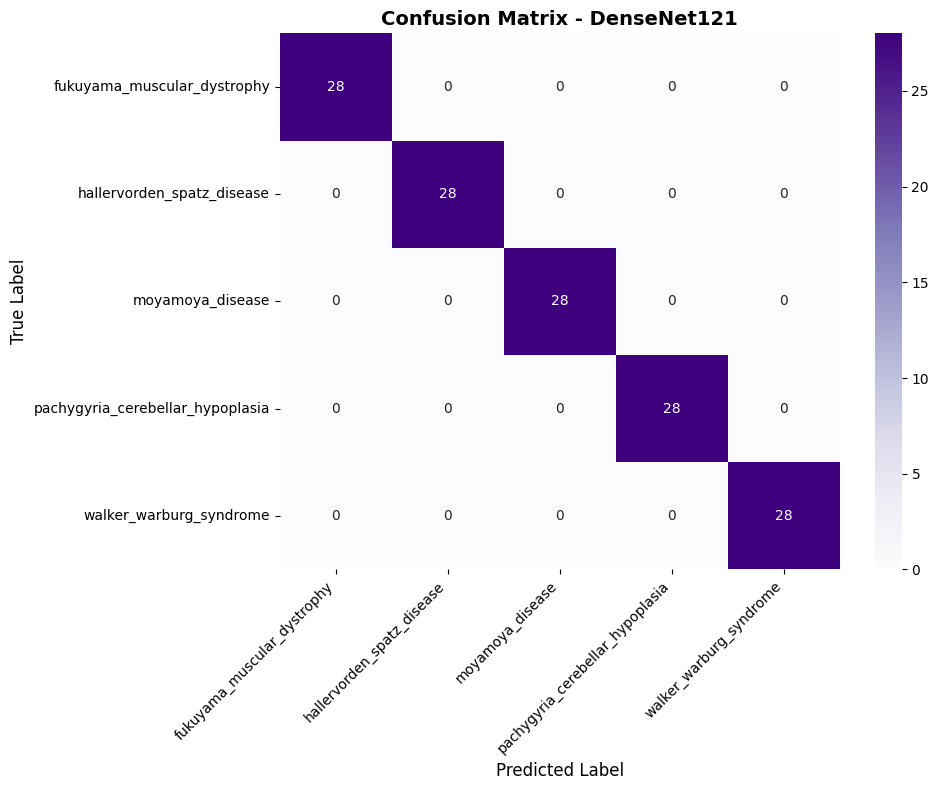

In [9]:
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - DenseNet121', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('densenet121_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

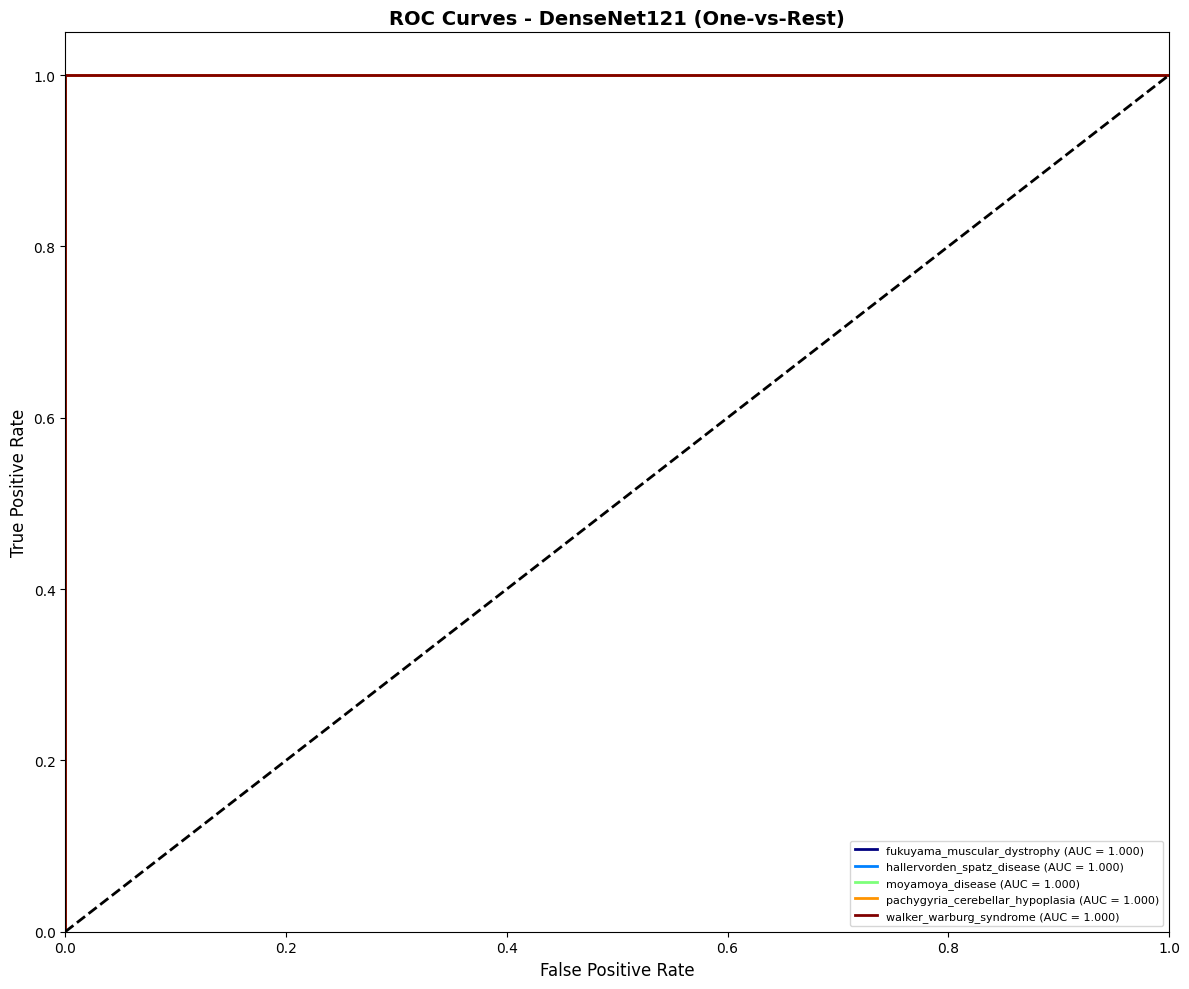

In [10]:

from sklearn.calibration import label_binarize
from sklearn.metrics import roc_curve, auc

y_true_bin = label_binarize(true_classes, classes=list(range(num_classes)))
y_score = predictions

plt.figure(figsize=(12, 10))
colors = plt.cm.jet(np.linspace(0, 1, num_classes))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i], lw=2,
             label=f'{class_names[i]} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - DenseNet121 (One-vs-Rest)', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=8)
plt.tight_layout()
plt.savefig('densenet121_roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

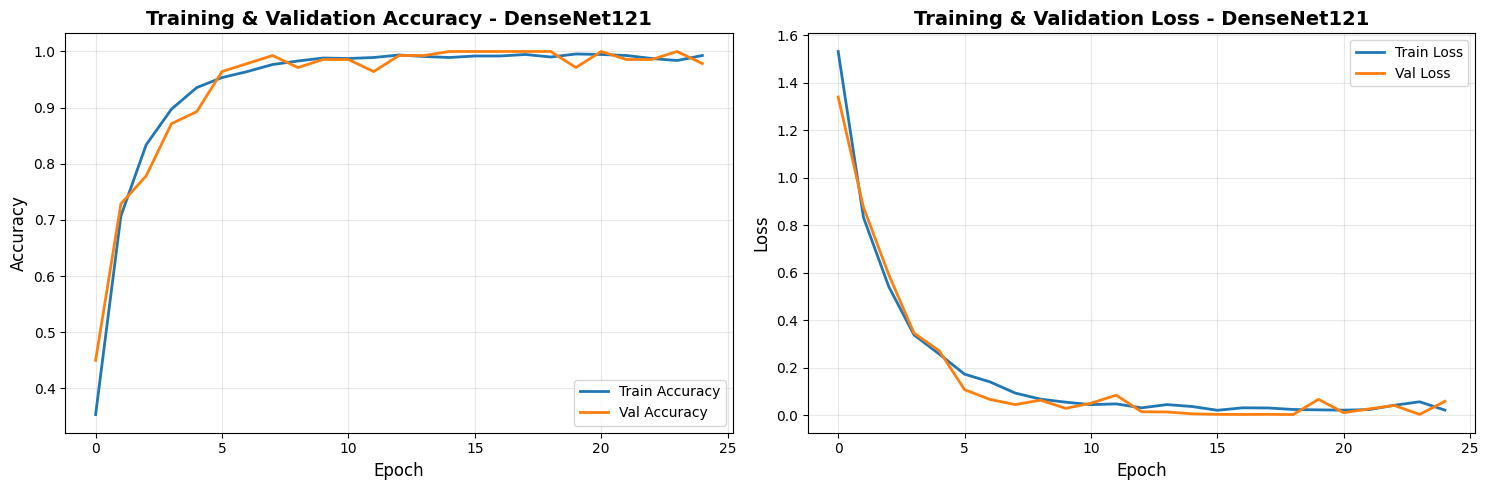

In [11]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Training & Validation Accuracy - DenseNet121', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training & Validation Loss - DenseNet121', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('densenet121_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

In [12]:
model.save('densenet121.h5')
print("\nModel saved as 'densenet121.h5'")
print("Best model weights saved as 'best_densenet121_tf_model.h5'")


Model saved as 'densenet121.h5'
Best model weights saved as 'best_densenet121_tf_model.h5'
